# Treasure Hunters Inc.

The goal of this project is to use reinforcement learning in a grid environment to avoid obstacles and reach the goal. This is done defining cost and reward functions with **Markov Decision Processes (MDP)**  

In [ ]:
Recall the basic ideas of Reinforcement Learning:

## Basic idea:

* Receive feedback in the form of rewards
* Agent’s utility is defined by the reward function
* Must (learn to) act so as to maximize expected rewards 

In [ ]:
## Grid World

* The agent lives in a grid
* Walls block the agent’s path
* The agent’s actions do not always go as planned
* Small rewards at each step
* Big rewards come at the end
* Goal: maximize sum of rewards

In [ ]:
We will make use of **Markov Decision Processes**.

## Markov Decision Processes


* An MDP is defined by:
    * A set of states s ∈ S
    * A set of actions a ∈ A
    * A **transition function** T(s,a,s’)
    * A **reward function** R(s, a, s’)
    * A **start state** (or distribution)
    * A **terminal state** 

First we import all the libraries that we will use in this example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2

Now we need to define all the above functions and probabilities. In order to do that, we define a class  called **GridWorldMDP**. With it we can define a function of the dollowing parameters:

* reward_grid,
* terminal_mask,
* obstacle_mask,
* action_probabilities,
* no_action_probability

With them we run a **Markov Decision Processes** below.

In [2]:
class GridWorldMDP:

    # up, right, down, left
    _direction_deltas = [
        (-1, 0),
        (0, 1),
        (1, 0),
        (0, -1),
    ]
    _num_actions = len(_direction_deltas)

    def __init__(self,
                 reward_grid,
                 terminal_mask,
                 obstacle_mask,
                 action_probabilities,
                 no_action_probability):

        self._reward_grid = reward_grid
        self._terminal_mask = terminal_mask
        self._obstacle_mask = obstacle_mask
        self._T = self._create_transition_matrix(
            action_probabilities,
            no_action_probability,
            obstacle_mask
        )

    @property
    def shape(self):
        return self._reward_grid.shape

    @property
    def size(self):
        return self._reward_grid.size

    @property
    def reward_grid(self):
        return self._reward_grid

    def run_value_iterations(self, discount=1.0,
                             iterations=10):
        utility_grids, policy_grids = self._init_utility_policy_storage(iterations)

        utility_grid = np.zeros_like(self._reward_grid)
        for i in range(iterations):
            utility_grid = self._value_iteration(utility_grid=utility_grid)
            policy_grids[:, :, i] = self.best_policy(utility_grid)
            utility_grids[:, :, i] = utility_grid
        return policy_grids, utility_grids

    def run_policy_iterations(self, discount=1.0,
                              iterations=10):
        utility_grids, policy_grids = self._init_utility_policy_storage(iterations)

        policy_grid = np.random.randint(0, self._num_actions,
                                        self.shape)
        utility_grid = self._reward_grid.copy()

        for i in range(iterations):
            policy_grid, utility_grid = self._policy_iteration(
                policy_grid=policy_grid,
                utility_grid=utility_grid
            )
            policy_grids[:, :, i] = policy_grid
            utility_grids[:, :, i] = utility_grid
        return policy_grids, utility_grids

    def generate_experience(self, current_state_idx, action_idx):
        sr, sc = self.grid_indices_to_coordinates(current_state_idx)
        next_state_probs = self._T[sr, sc, action_idx, :, :].flatten()

        next_state_idx = np.random.choice(np.arange(next_state_probs.size),
                                          p=next_state_probs)

        return (next_state_idx,
                self._reward_grid.flatten()[next_state_idx],
                self._terminal_mask.flatten()[next_state_idx])

    def grid_indices_to_coordinates(self, indices=None):
        if indices is None:
            indices = np.arange(self.size)
        return np.unravel_index(indices, self.shape)

    def grid_coordinates_to_indices(self, coordinates=None):
        # Annoyingly, this doesn't work for negative indices.
        # The mode='wrap' parameter only works on positive indices.
        if coordinates is None:
            return np.arange(self.size)
        return np.ravel_multi_index(coordinates, self.shape)

    def best_policy(self, utility_grid):
        M, N = self.shape
        return np.argmax((utility_grid.reshape((1, 1, 1, M, N)) * self._T)
                         .sum(axis=-1).sum(axis=-1), axis=2)

    def _init_utility_policy_storage(self, depth):
        M, N = self.shape
        utility_grids = np.zeros((M, N, depth))
        policy_grids = np.zeros_like(utility_grids)
        return utility_grids, policy_grids

    def _create_transition_matrix(self,
                                  action_probabilities,
                                  no_action_probability,
                                  obstacle_mask):
        M, N = self.shape

        T = np.zeros((M, N, self._num_actions, M, N))

        r0, c0 = self.grid_indices_to_coordinates()

        T[r0, c0, :, r0, c0] += no_action_probability

        for action in range(self._num_actions):
            for offset, P in action_probabilities:
                direction = (action + offset) % self._num_actions

                dr, dc = self._direction_deltas[direction]
                r1 = np.clip(r0 + dr, 0, M - 1)
                c1 = np.clip(c0 + dc, 0, N - 1)

                temp_mask = obstacle_mask[r1, c1].flatten()
                r1[temp_mask] = r0[temp_mask]
                c1[temp_mask] = c0[temp_mask]

                T[r0, c0, action, r1, c1] += P

        terminal_locs = np.where(self._terminal_mask.flatten())[0]
        T[r0[terminal_locs], c0[terminal_locs], :, :, :] = 0
        return T

    def _value_iteration(self, utility_grid, discount=1.0):
        out = np.zeros_like(utility_grid)
        M, N = self.shape
        for i in range(M):
            for j in range(N):
                out[i, j] = self._calculate_utility((i, j),
                                                    discount,
                                                    utility_grid)
        return out

    def _policy_iteration(self, *, utility_grid,
                          policy_grid, discount=1.0):
        r, c = self.grid_indices_to_coordinates()

        M, N = self.shape

        utility_grid = (
            self._reward_grid +
            discount * ((utility_grid.reshape((1, 1, 1, M, N)) * self._T)
                        .sum(axis=-1).sum(axis=-1))[r, c, policy_grid.flatten()]
            .reshape(self.shape)
        )

        utility_grid[self._terminal_mask] = self._reward_grid[self._terminal_mask]

        return self.best_policy(utility_grid), utility_grid

    def _calculate_utility(self, loc, discount, utility_grid):
        if self._terminal_mask[loc]:
            return self._reward_grid[loc]
        row, col = loc
        return np.max(
            discount * np.sum(
                np.sum(self._T[row, col, :, :, :] * utility_grid,
                       axis=-1),
                axis=-1)
        ) + self._reward_grid[loc]

    def plot_policy(self, utility_grid, policy_grid=None):
        if policy_grid is None:
            policy_grid = self.best_policy(utility_grid)
        markers = "^>v<"
        marker_size = 100 // np.max(policy_grid.shape)
        marker_edge_width = marker_size // 10
        marker_fill_color = 'w'

        no_action_mask = self._terminal_mask | self._obstacle_mask

        utility_normalized = (utility_grid - utility_grid.min()) / \
                             (utility_grid.max() - utility_grid.min())

        utility_normalized = (255*utility_normalized).astype(np.uint8)

        utility_rgb = cv2.applyColorMap(utility_normalized, cv2.COLORMAP_JET)
        for i in range(3):
            channel = utility_rgb[:, :, i]
            channel[self._obstacle_mask] = 0

        plt.imshow(utility_rgb[:, :, ::-1], interpolation='none')
            
        for i, marker in enumerate(markers):
            y, x = np.where((policy_grid == i) & np.logical_not(no_action_mask))
            plt.plot(x, y, marker, ms=marker_size, mew=marker_edge_width, color=marker_fill_color)

        y, x = np.where(self._terminal_mask)
        plt.plot(x, y, 'o', ms=marker_size, mew=marker_edge_width, color=marker_fill_color)

        tick_step_options = np.array([1, 2, 5, 10, 20, 50, 100])
        tick_step = np.max(policy_grid.shape)/8
        best_option = np.argmin(np.abs(np.log(tick_step) - np.log(tick_step_options)))
        tick_step = tick_step_options[best_option]
        plt.xticks(np.arange(0, policy_grid.shape[1] - 0.5, tick_step))
        plt.yticks(np.arange(0, policy_grid.shape[0] - 0.5, tick_step))
        plt.xlim([-0.5, policy_grid.shape[0]-0.5])
        plt.xlim([-0.5, policy_grid.shape[1]-0.5])

Now let's run our first toy example. To make it easier, let's use a 2x2 grid.

The game starts at the left bottom corner.

The end is the top right corner.

## Setting a 3x3 game with One Obstacle

In [3]:
shape = (3, 3)
goal = (0, 2)
trap = ((1, 1))
obstacle = (1, 1)
start = (-3, 0)
default_reward = -0.1
goal_reward = 2
trap_reward = -1

reward_grid = np.zeros(shape) + default_reward
reward_grid[goal] = goal_reward
reward_grid[trap] = trap_reward
reward_grid[obstacle] = 1

terminal_mask = np.zeros_like(reward_grid, dtype=np.bool)
terminal_mask[goal] = True
terminal_mask[trap] = False

obstacle_mask = np.zeros_like(reward_grid, dtype=np.bool)
obstacle_mask[1, 1] = True

Below we just want to show how the game look like

In [4]:
reward_grid

array([[-0.1, -0.1,  2. ],
       [-0.1,  1. , -0.1],
       [-0.1, -0.1, -0.1]])

In [5]:
terminal_mask

array([[False, False,  True],
       [False, False, False],
       [False, False, False]], dtype=bool)

In [6]:
obstacle_mask

array([[False, False, False],
       [False,  True, False],
       [False, False, False]], dtype=bool)

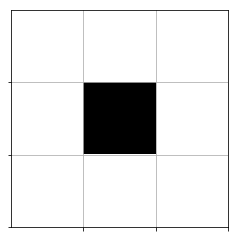

In [7]:
plt.figure(1)
plt.grid('on')
nrows, ncols =shape
ax = plt.gca()
ax.set_xticks(np.arange(0.5, nrows, 1))
ax.set_yticks(np.arange(0.5, ncols, 1))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.imshow(obstacle_mask*-1, cmap='gray', interpolation='nearest')

In [8]:
gw = GridWorldMDP(reward_grid=reward_grid,
                     obstacle_mask=obstacle_mask,
                     terminal_mask=terminal_mask,
                     action_probabilities=[
                         (-1, 0.1),
                         (0, 0.8),
                         (1, 0.1),
                     ],
                     no_action_probability=0.0)
mdp_solvers = {'Value Iteration': gw.run_value_iterations,
                'Policy Iteration': gw.run_policy_iterations}

Now we print the results of our policy and utility.

In [9]:
for solver_name, solver_fn in mdp_solvers.items():
        print('Final result of {}:'.format(solver_name))
        policy_grids, utility_grids = solver_fn(iterations=25, discount=0.5)
        print(policy_grids[:, :, -1])
        print(utility_grids[:, :, -1])

Final result of Value Iteration:
[[ 1.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  1.  0.]]
[[ 1.73437499  1.875       2.        ]
 [ 1.60937497  2.84843749  1.875     ]
 [ 1.49826381  1.60937497  1.73437499]]
Final result of Policy Iteration:
[[ 1.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  1.  0.]]
[[ 1.73437499  1.875       2.        ]
 [ 1.60937497  2.84843749  1.875     ]
 [ 1.49826381  1.60937497  1.73437499]]


Plotting the final result of this toy example.

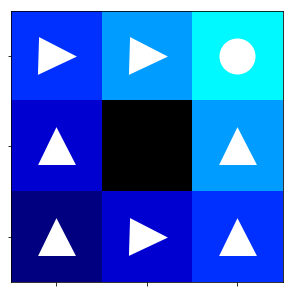

In [10]:
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
gw.plot_policy(utility_grids[:, :, -1])
plt.show()

Therefore, there are two possible solutions. Starting from the bottom, we can either start moving right or up and we will avoid the obstacle and reach the goal with the same number of steps.

## Setting a 5x5 game with Two Obstacles

In [11]:
shape = (5, 5)
goal = (0, 4)
trap = ((1,1))
obstacle1 = (1,1)
obstacle2 = (3,3)
start = (-4, 0)
default_reward = -0.1
goal_reward = 2
trap_reward = -1

reward_grid = np.zeros(shape) + default_reward
reward_grid[goal] = goal_reward
reward_grid[trap] = trap_reward
reward_grid[obstacle1] = 1
reward_grid[obstacle2] = 1

terminal_mask = np.zeros_like(reward_grid, dtype=np.bool)
terminal_mask[goal] = True
terminal_mask[trap] = False

obstacle_mask = np.zeros_like(reward_grid, dtype=np.bool)
obstacle_mask[obstacle1] = True
obstacle_mask[obstacle2] = True

In [12]:
reward_grid

array([[-0.1, -0.1, -0.1, -0.1,  2. ],
       [-0.1,  1. , -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1,  1. , -0.1],
       [-0.1, -0.1, -0.1, -0.1, -0.1]])

In [13]:
terminal_mask

array([[False, False, False, False,  True],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]], dtype=bool)

In [14]:
obstacle_mask

array([[False, False, False, False, False],
       [False,  True, False, False, False],
       [False, False, False, False, False],
       [False, False, False,  True, False],
       [False, False, False, False, False]], dtype=bool)

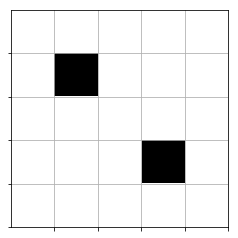

In [15]:
plt.figure(1)
plt.grid('on')
nrows, ncols =shape
ax = plt.gca()
ax.set_xticks(np.arange(0.5, nrows, 1))
ax.set_yticks(np.arange(0.5, ncols, 1))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.imshow(obstacle_mask*-1, cmap='gray', interpolation='nearest')

In [16]:
gw = GridWorldMDP(reward_grid=reward_grid,
                     obstacle_mask=obstacle_mask,
                     terminal_mask=terminal_mask,
                     action_probabilities=[
                         (-1, 0.1),
                         (0, 0.8),
                         (1, 0.1),
                     ],
                     no_action_probability=0.0)
mdp_solvers = {'Value Iteration': gw.run_value_iterations,
                'Policy Iteration': gw.run_policy_iterations}

In [17]:
for solver_name, solver_fn in mdp_solvers.items():
        print('Final result of {}:'.format(solver_name))
        policy_grids, utility_grids = solver_fn(iterations=25, discount=0.5)
        print(policy_grids[:, :, -1])
        print(utility_grids[:, :, -1])

Final result of Value Iteration:
[[ 1.  1.  1.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.]]
[[ 1.45507297  1.59570002  1.72070027  1.85939664  2.        ]
 [ 1.33006887  2.58286934  1.61113005  1.73456992  1.85939664]
 [ 1.22049316  1.3439692   1.48441235  1.61113005  1.72070027]
 [ 1.10935988  1.22049255  1.3439692   2.58286934  1.59570002]
 [ 0.99820028  1.10935988  1.22049316  1.33006887  1.45507297]]
Final result of Policy Iteration:
[[ 1.  1.  1.  1.  0.]
 [ 0.  1.  0.  1.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.]]
[[ 1.45507298  1.59570002  1.72070027  1.85939664  2.        ]
 [ 1.3300689   2.58286935  1.61113005  1.73456992  1.85939664]
 [ 1.22049321  1.34396926  1.48441236  1.61113005  1.72070027]
 [ 1.10935999  1.22049268  1.34396926  2.58286935  1.59570002]
 [ 0.99820071  1.1093601   1.22049325  1.33006891  1.45507299]]


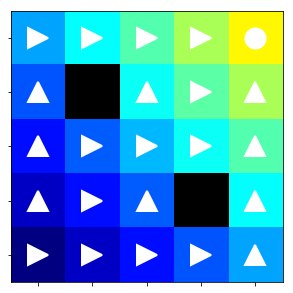

In [18]:
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
gw.plot_policy(utility_grids[:, :, -1])
plt.show()

Therefore, the best solution starting from the bottom, we should start moving up until we reach the limit, and then we move straight right to reach the goal.